# Train and Deploy

## Overview

This notebook is split into the following sections:
- Setup and imports
- Load and prepare dataset
- Train a Random Forest Classifier using a custom script
  - In the notebook
  - From the command line
  - As SageMaker Training job (in a Docker container)
- Deployment
  - Realtime Endpoint
  - Serverless Inference
  - Options

## Overview SageMaker **Training**

![Overview SageMaker Training](img/training_script_mode.png)

## Setup and Imports

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

We ran this notebook using Amazon SageMaker with the version you see in the output of the next cell below. If your version is lower and you encounter issues, we recommend uncommenting the code below to upgrade your pip and SageMaker versions. Make sure to restart your kernel after upgrading for the changes to take effect.

In [2]:
!pip install -Uq sagemaker

In [3]:
import sagemaker

sagemaker.__version__ 

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


'2.212.0'

In [4]:
import os
import pandas as pd
import numpy as np
import boto3

In [5]:
# SDK setup
role = sagemaker.get_execution_role()
region = boto3.Session().region_name
sm = boto3.client('sagemaker')
boto_sess = boto3.Session(region_name=region)
sm_sess = sagemaker.session.Session(boto_session=boto_sess, sagemaker_client=sm)

In [6]:
# Data layout and locations. 
# To store our data we are using a prefix in the Amazon SageMaker default bucket. Feel free to adjust to your preferences.

BUCKET = sm_sess.default_bucket()
PREFIX = 'train-deploy-demo'
s3_data_url = f's3://{BUCKET}/{PREFIX}/data'

## Load and Prepare dataset

In [7]:
!mkdir -p data

The actual task and data only play a supporting role. But to give some brief context, we are optimizing the hyperparameters of a Random Forest model that should classify handwritten digits.

We use the Optical Recognition of Handwritten Digits Data Set via scikit-learn:

_Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science._

In [8]:
from sklearn import datasets

digits         = datasets.load_digits()
digits_df      = pd.DataFrame(digits.data)
digits_df['y'] = digits.target

digit: 4


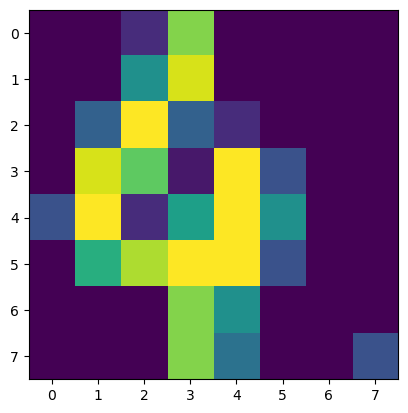

In [9]:
from matplotlib import pyplot as plt

print('digit:', int(digits_df.iloc[100].y))
plt.imshow(digits_df.iloc[100, 1:].values.reshape(8, -1));

In [10]:
digits_df.to_csv('data/digits.csv', index=False)

In [11]:
!aws s3 sync data/ {s3_data_url} --exclude '*' --include 'digits.csv'

upload: data/digits.csv to s3://sagemaker-eu-west-1-753739741425/train-deploy-demo/data/digits.csv


## Prepare Training

Below we define our training script that we will pass on to SageMaker to run our training. Note that we chose to directly write the required files from our Jupyter Notebook to the `src/` directory using the command `%%writefile`. This is to make this sample more readable and keep all relevant code in one place in this notebook. You can find the source files in the `src/` directory locally in the notebook.


In [12]:
!mkdir -p src
import sys
sys.path.append('src')

### Dependencies and training containers 
When running our training, we often rely on some functions from other libraries and dependecies. In our case, we use functions from the `scikit-learn` and `pandas` libraries.

Luckily, SageMaker offers [several Frameworks](https://sagemaker.readthedocs.io/en/stable/frameworks/index.html) that come pre-installed with popular data science and ML frameworks such Scikit-learn, PyTorch and TensorFlow.

For our purposes in this notebook, we'll be using the [Scikit-learn Framework](https://sagemaker.readthedocs.io/en/stable/frameworks/sklearn/using_sklearn.html#prepare-a-scikit-learn-training-script) that has everything we need for our training.

### (Optional) Defining a requirements.txt file
One common practice to collect and organise dependencies and external libraries in Python, is to define a `requirements.txt` file containing a list of imported libraries and their versions.

Although our Scikit-learn container provides us with all the libraries we need, if we needed access to libraries not included in the provided container, we could also define these in `requirements.txt`.

Defining a `requirements.txt` file is an optional step, and not required to launch SageMaker training but it is supported if you wish to include it. SageMaker will automatically use our specified source directory, containing our `train.py` and possibly a `requirements.txt`. For more information, see the [documentation here](https://sagemaker.readthedocs.io/en/stable/frameworks/sklearn/using_sklearn.html#using-third-party-libraries).

In [13]:
%%writefile src/requirements.txt

# Not necessary for our training but we may define additional libraries here as required
#[optional-additional-libraries]

Overwriting src/requirements.txt


In [14]:
%%writefile src/inference.py

import os
import io
from pathlib import Path

import pandas as pd
import numpy as np

import joblib

# Inference:
# https://sagemaker.readthedocs.io/en/stable/frameworks/sklearn/using_sklearn.html#serve-a-model
#https://github.com/aws/sagemaker-scikit-learn-container/blob/master/src/sagemaker_sklearn_container/serving.py#L76
def model_fn(model_dir):
    """
    Load the model from the disk.
    On subsequent requests to the predict_fn it will be presented as a parameter.
    """
    model = joblib.load(Path(model_dir)/"model.joblib")
    return model

def input_fn(request_body, accept):
    """
    Deserialize and prepare the prediction input.
    Here, we assume the input is a CSV string; you can modify it according to your needs.
    """
    if accept == "text/csv":
        # Convert the CSV string to a numpy array
        input_data = np.array([np.fromstring(line, sep=",") for line in request_body.strip().split("\n")])
    elif accept == "application/x-npy":
        # Load numpy array from binary data
        stream = io.BytesIO(request_body)
        input_data = np.load(stream)
    else:
        raise ValueError(f"Unsupported content type: {accept}")
    
    return input_data

def predict_fn(input_data, model):
    """
    Make a prediction using the input data and the model.
    """
    prediction = model.predict(input_data)
    return prediction

def output_fn(prediction, accept):
    """
    Serialize and prepare the prediction output to CSV
    """
    if accept == "text/csv":
        output = ','.join([str(p) for p in prediction])
    elif accept == "application/x-npy":
        buffer = io.BytesIO()
        np.save(buffer, prediction)
        buffer.seek(0)  
        output = buffer.getvalue()
    else:
        raise ValueError(f"Unsupported content type: {accept}")

    return output, accept


Overwriting src/inference.py


### Defining our custom training script (train.py)
The training code we are going to use is implemented in Python and mainly contains a method called 'fit'. This method creates a new Random Forest classifier and passes on most of its parameters as hyperparameters before calling the fit method on the classifier. Additionally, some arguments are supported for directly calling the train.py script.

In [15]:
%%writefile src/train.py

#!/usr/bin/env python
import argparse
import os
import traceback
from pathlib import Path

import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split

import joblib

def fit(train_dir, n_estimators, max_depth, min_samples_leaf, max_features, min_weight_fraction_leaf):
    
    digits = pd.read_csv(Path(train_dir)/'digits.csv')
    
    Xtrain, Xtest, ytrain, ytest = train_test_split(digits.iloc[:, :-1], digits.iloc[:, -1], test_size=.2)
    
    m = RandomForestClassifier(n_estimators=n_estimators, 
                               max_depth=max_depth, 
                               min_samples_leaf=min_samples_leaf,
                               max_features=max_features,
                               min_weight_fraction_leaf=min_weight_fraction_leaf)
    m.fit(Xtrain, ytrain)
    predicted = m.predict(Xtest)
    pre, rec, f1, _ = precision_recall_fscore_support(ytest, predicted, pos_label=1, average='weighted')
    
    print(f'pre: {pre:5.3f} rec: {rec:5.3f} f1: {f1:5.3}')
    
    return m

if __name__ =='__main__':

    parser = argparse.ArgumentParser()

    # hyperparameters sent by the client are passed as command-line arguments to the script.

    parser.add_argument('--train', type=str, default=os.environ.get('SM_CHANNEL_TRAIN'))
    parser.add_argument('--model-dir', type=str, default=os.environ.get('SM_MODEL_DIR'))

    parser.add_argument('--n-estimators', type=int, default=100)
    parser.add_argument('--max-depth', type=int, default=10)
    parser.add_argument('--min-samples-leaf', type=int, default=1)
    parser.add_argument('--max-features', type=str, default=None)
    parser.add_argument('--min-weight-fraction-leaf', type=float, default=0.01)

    args, _ = parser.parse_known_args()
    trained_model = fit(train_dir=args.train, 
                        n_estimators=args.n_estimators, 
                        max_depth=args.max_depth,
                        min_samples_leaf=args.min_samples_leaf,
                        max_features=args.max_features,
                        min_weight_fraction_leaf=args.min_weight_fraction_leaf)
    
    joblib.dump(trained_model, os.path.join(args.model_dir, 'model.joblib'))   

# Inference:
# https://sagemaker.readthedocs.io/en/stable/frameworks/sklearn/using_sklearn.html#serve-a-model
# https://github.com/aws/sagemaker-scikit-learn-container/blob/master/src/sagemaker_sklearn_container/serving.py#L76
simple = False
if simple:
    def model_fn(model_dir):
        """
        Load the model from the disk.
        On subsequent requests to the predict_fn it will be presented as a parameter.
        """
        model = joblib.load(Path(model_dir)/"model.joblib")
        return model
else:
    from inference import model_fn, input_fn, predict_fn, output_fn

Overwriting src/train.py


#### Test run our training script locally
Now that we have prepared our training script, let's quickly run it locally to check that it works before you submit it to a container-based training. We run our training script directly from this notebook, which makes it possible to use the Python Debugger and other utilities.

In [16]:
# Running the code from within the notebook. It would then be possible to use the Python Debugger, pdb.
from train import fit
fit('data', 100, 10, 1, None, 0.01)

pre: 0.870 rec: 0.869 f1: 0.869


RandomForestClassifier(max_depth=10, max_features=None,
                       min_weight_fraction_leaf=0.01)

We could also run it directly from the command line. Doing so would trigger the `if __name__ =='__main__':` statement in our script, to parse our command line arguments. That's a great way to test your argument parsing.

When SageMaker loads the container with our script into the training instance, SageMaker will also launch our train.py via the command line.

In [17]:
!cd src && python train.py --train ../data/ --model-dir /tmp/ --n-estimators 100

pre: 0.903 rec: 0.900 f1:   0.9


## Run Training in Containers

With our `train.py` tested, we are ready to create our estimator and call `fit()` to start our training.

### Define our metrics

Recall that in our first notebook, we used a built-in Algorithm for our training. This pre-built container and training script by SageMaker came already configured with its own metrics and metrics defintions. Since we are using a custom training script in this notebook, we now must specify our metrics to SageMaker.

In our `train.py`, we used `print(f'pre: {pre:5.3f} rec: {rec:5.3f} f1: {f1:5.3}')` to emit metrics from our training. During training, this information is printed to `std.out`, which is parsed by SageMaker and sent to Amazon CloudWatch.

In order for SageMaker to successfully parse our metrics, we must provide the Regular Expressions (REGEX), that instruct SageMaker how to extract the numerical values from our print statement above, as described [in the documentation here](https://docs.aws.amazon.com/sagemaker/latest/dg/training-metrics.html). We do this with our `metric_definitions` object below, which we then pass as a parameter to our estimator. 

Note: The metrics we chose here will eventually be used by SageMaker AMT for our HPO jobs, more [information on tuning metrics can be found here](https://docs.aws.amazon.com/sagemaker/latest/dg/automatic-model-tuning-define-metrics-variables.html)

In [18]:
metric_definitions = [{'Name': 'valid-precision',  'Regex': r'pre:\s+(-?[0-9\.]+)'},
                      {'Name': 'valid-recall',     'Regex': r'rec:\s+(-?[0-9\.]+)'},
                      {'Name': 'valid-f1',         'Regex': r'f1:\s+(-?[0-9\.]+)'}]                            

In the following cells, we define our estimator, in which we pass our training script, indicate our source directory and specify our training instance configuration with the `instance_type` and `instance_count` variables.

Notice that, we are using an SKLearn estimator, which instructs SageMaker to load our training script onto a container that comes with Scikit-learn and other dependencies pre-installed. The `framework_version` parameter in the estimator defines which Scikit-learn version we wish to run. You  can read more about the parameters [here](https://sagemaker.readthedocs.io/en/stable/frameworks/sklearn/sagemaker.sklearn.html)

This differs from the estimator used in our [1_tuning_of_builtin_xgboost.ipynb](https://github.com/aws-samples/amazon-sagemaker-amt-visualize/blob/main/1_tuning_of_builtin_xgboost.ipynb) notebook, which we used to run built-in algorithms rather than custom training scripts.

In [19]:
from sagemaker.sklearn.estimator import SKLearn
from sagemaker import get_execution_role

In [20]:
# from sagemaker.local import LocalSession

# sagemaker_session = LocalSession()
# sagemaker_session.config = {'local': {'local_code': True}}

In [21]:
estimator = SKLearn(
    'train.py',
    source_dir='src',
    role=get_execution_role(),
    instance_type= 'ml.m5.large',
    instance_count=1,
    framework_version='1.2-1', 
    metric_definitions=metric_definitions,

    # Uncomment the following three lines to use Managed Spot Training
    # use_spot_instances= True,
    # max_run=  60 * 60 * 24,
    # max_wait= 60 * 60 * 24,

    hyperparameters = {'n-estimators': 250,
                       'max-depth': 24,
                       'min-samples-leaf': 1,
                       'max-features': 'log2',
                       'min-weight-fraction-leaf': 0.00187}
)

Now let's run the estimator's fit function to train the model using the full training set. This will take a few minutes.

In [22]:
print(s3_data_url)
estimator.fit({'train': s3_data_url}, wait=True)

s3://sagemaker-eu-west-1-753739741425/train-deploy-demo/data


INFO:sagemaker:Creating training-job with name: sagemaker-scikit-learn-2024-03-12-16-47-15-166


2024-03-12 16:47:15 Starting - Starting the training job...
2024-03-12 16:47:32 Starting - Preparing the instances for training......
2024-03-12 16:48:23 Downloading - Downloading input data...
2024-03-12 16:49:13 Downloading - Downloading the training image......
2024-03-12 16:50:14 Training - Training image download completed. Training in progress.
2024-03-12 16:50:14 Uploading - Uploading generated training model2024-03-12 16:50:06,446 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2024-03-12 16:50:06,450 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-03-12 16:50:06,452 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2024-03-12 16:50:06,473 sagemaker_sklearn_container.training INFO     Invoking user training script.
2024-03-12 16:50:06,735 sagemaker-training-toolkit INFO     Installing dependencies from requirements.txt:
/miniconda3/bin/python -m pip install -r re

# Deploy to Realtime Endpoint
[![Docs](img/model-builder-serialization.png)](https://docs.aws.amazon.com/sagemaker/latest/dg/how-it-works-modelbuilder-creation.html)

In [23]:
%%time
predictor = estimator.deploy(
    initial_instance_count=1, 
    instance_type='ml.t2.medium',
    serializer=sagemaker.serializers.CSVSerializer(),
    deserializer=sagemaker.deserializers.NumpyDeserializer()
)

INFO:sagemaker:Creating model with name: sagemaker-scikit-learn-2024-03-12-16-50-57-707
INFO:sagemaker:Creating endpoint-config with name sagemaker-scikit-learn-2024-03-12-16-50-57-707
INFO:sagemaker:Creating endpoint with name sagemaker-scikit-learn-2024-03-12-16-50-57-707


----------!CPU times: user 90.6 ms, sys: 14.5 ms, total: 105 ms
Wall time: 5min 32s


In [24]:
samples = digits_df.iloc[:20, :-1]; samples[:5] # Training Data!

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,9.0,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0


In [25]:
list(digits_df['y'][:20])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [26]:
#%%time
y_pred = predictor.predict(samples)
y_pred

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

# Manual Deploy, i.e. from the artifacts tarball, not from the model
# https://docs.aws.amazon.com/sagemaker/latest/dg/realtime-endpoints-deployment.html

In [27]:
# from sagemaker import image_uris
# container = image_uris.retrieve(region=sagemaker_session.boto_region_name,
#                                 framework='pytorch', 
#                                 py_version='py38',
#                                 image_scope='inference',
#                                 instance_type='ml.c5.xlarge',
#                                 version='1.10')

In [28]:
# from sagemaker.pytorch.model import PyTorchModel

# pt_model = PyTorchModel(image_uri=container, 
#               model_data='s3://sagemaker-eu-west-1-811243659808/pytorch-training-2022-05-20-11-53-15-656/output/model.tar.gz', 
#               role=role, 
#               source_dir="source", # be aware, that we are here uploading our code from
#               entry_point="cifar10.py",
#               framework_version="1.10",
#               py_version="py38",
#             )

In [29]:
# from datetime import datetime
# endpoint_name = f"DEMO-{datetime.utcnow():%Y-%m-%d-%H%M}"
# print("EndpointName =", endpoint_name)

In [30]:
# predictor_manual = sagemaker.pytorch.model.PyTorchPredictor(endpoint_name)

In [31]:
# eval_model(predictor_manual) # predictor_manual.predict(...)

In [32]:
# predictor_manual.delete_endpoint()

# Lambda "ServerlessInference"

In [33]:
# Just for reference, to make an easy comparison
# %%time
# predictor = estimator.deploy(
#     initial_instance_count=1, 
#     instance_type='ml.t2.medium',
#     serializer=sagemaker.serializers.CSVSerializer()
# )

In [34]:
%%time
serverless_inference_config = sagemaker.serverless.serverless_inference_config.ServerlessInferenceConfig(
    memory_size_in_mb=2048, 
    max_concurrency=100
)
serverless_predictor = estimator.deploy(
    serverless_inference_config=serverless_inference_config,
    serializer=sagemaker.serializers.CSVSerializer()
)

INFO:sagemaker:Creating model with name: sagemaker-scikit-learn-2024-03-12-16-56-30-740
INFO:sagemaker:Creating endpoint-config with name sagemaker-scikit-learn-2024-03-12-16-56-30-740
INFO:sagemaker:Creating endpoint with name sagemaker-scikit-learn-2024-03-12-16-56-30-740


-----!CPU times: user 42.2 ms, sys: 8.29 ms, total: 50.5 ms
Wall time: 3min 2s


In [35]:
%%time
serverless_predictor.predict(samples)

CPU times: user 18.3 ms, sys: 0 ns, total: 18.3 ms
Wall time: 933 ms


array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [36]:
%%time
serverless_predictor.predict(samples)

CPU times: user 4.99 ms, sys: 323 µs, total: 5.31 ms
Wall time: 50.3 ms


array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

## Cleanup 

To avoid incurring unwanted costs when you’re done experimenting with HPO, you must remove all files in your S3 bucket with the prefix `train-deploy-demoo` and also [shut down Studio resources](https://docs.aws.amazon.com/sagemaker/latest/dg/notebooks-run-and-manage-shut-down.html).

Uncomment and run the following code to remove all S3 files created by this notebook. Note that`{BUCKET}` is the variable with our bucket name that we defined earlier, you may also write your bucket name as plaintext here.

If you wish to keep the datasets or the model artifacts, you may modify the prefix in the code to `train-deploy-demo/data` to only delete the data or `train-deploy-demo/output` to only delete the model artifacts.

In [37]:
predictor.delete_endpoint()
serverless_predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: sagemaker-scikit-learn-2024-03-12-16-50-57-707
INFO:sagemaker:Deleting endpoint with name: sagemaker-scikit-learn-2024-03-12-16-50-57-707
INFO:sagemaker:Deleting endpoint configuration with name: sagemaker-scikit-learn-2024-03-12-16-56-30-740
INFO:sagemaker:Deleting endpoint with name: sagemaker-scikit-learn-2024-03-12-16-56-30-740


In [38]:
#!aws s3 rm s3://{BUCKET}/train-deploy-demo --recursive

# Deployment Options
[![Docs](img/inference-workflow-options.png)](https://docs.aws.amazon.com/sagemaker/latest/dg/deploy-model.html#deploy-model-options)

In [39]:
df = pd.DataFrame({'a': [1,2,3], 'b': [4, 5, 6]})
df.columns

a = np.array([[1,2],[9,10], [11, 12]])
df2 = pd.DataFrame(a)

def prepare_df(df):
    columns = df.columns
    print(columns)
    df[columns[1]] = df[columns[1]]*2
    return df
prepare_df(df)

Index(['a', 'b'], dtype='object')


,a,b
0,1,8
1,2,10
2,3,12
